# Sagemaker-XGBoost-Demo

In [ ]:
# import libraries
import sagemaker, boto3, os
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from IPython.display import FileLink, FileLinks
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [ ]:
%conda install -c conda-forge shap # Install shap Python library
    #SHAP is the acronym for SHapley Additive exPlanations

In [ ]:
pip install shap==0.39.0 # Install shap Python library

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import shap #SHAP is the acronym for SHapley Additive exPlanations

In [ ]:
# Define IAM role

my_region = sagemaker.Session().boto_region_name # set the region of the instance
print("AWS Region: {}".format(my_region))

role = sagemaker.get_execution_role()
print("Role: {}".format(role))

prefix = 'sagemaker-xgboost'

AWS Region: us-east-1
Role: arn:aws:iam::471071075551:role/service-role/AmazonSageMaker-ExecutionRole-20211208T103977


## Explore and Transform Dataset

In [ ]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
feature_names = list(X.columns)
feature_names

['Age',
 'Workclass',
 'Education-Num',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Capital Gain',
 'Capital Loss',
 'Hours per week',
 'Country']

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581646,3.868892,10.080679,2.611836,6.572740,2.494518,3.665858,0.669205,1077.649170,87.303833,40.437454,36.718866
std,13.640442,1.455960,2.572562,1.506222,4.228857,1.758232,0.848806,0.470506,7385.911621,403.014771,12.347933,7.823782
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,4.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,39.000000
50%,37.000000,4.000000,10.000000,2.000000,7.000000,3.000000,4.000000,1.000000,0.000000,0.000000,40.000000,39.000000
75%,48.000000,4.000000,12.000000,4.000000,10.000000,4.000000,4.000000,1.000000,0.000000,0.000000,45.000000,39.000000
max,90.000000,8.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000


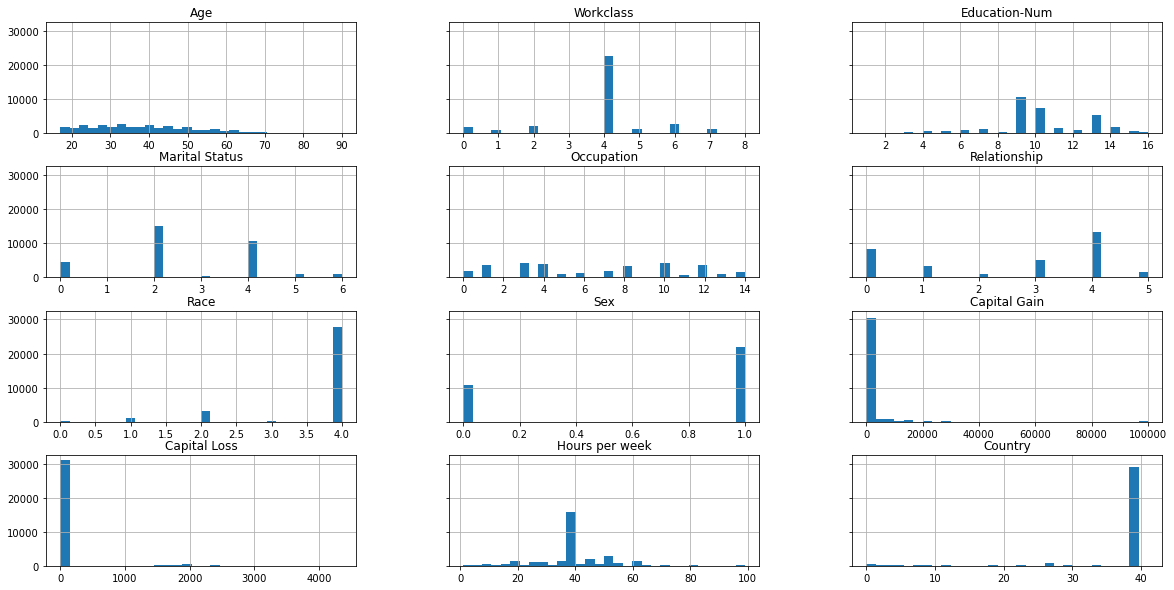

In [ ]:
display(X.describe())
hist =X.hist(bins=30, sharey=True, figsize=(20,10))

In [ ]:
# Train and Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_display = X_display.loc[X_train.index]

In [ ]:
#reformat the CSV data, dependent feature should be the first coloumn
import pandas as pd
train = pd.concat([pd.Series(y_train, index=X_train.index, name='Income>50K', dtype=int), X_train], axis=1)
test = pd.concat([pd.Series(y_test, index=X_test.index, name='Income>50K', dtype=int), X_test], axis=1)

In [ ]:
train

,Income>50K,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
16465,0,39.0,6,7.0,2,14,4,4,1,0.0,0.0,40.0,39
5625,1,54.0,6,13.0,2,4,4,4,1,0.0,0.0,40.0,39
30273,1,32.0,4,9.0,2,12,4,4,1,0.0,1902.0,50.0,39
3136,0,45.0,6,10.0,4,5,0,4,1,0.0,0.0,50.0,39
4521,0,60.0,4,6.0,2,6,4,2,1,0.0,0.0,40.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32511,0,25.0,2,13.0,4,1,3,2,0,0.0,0.0,40.0,39
5192,1,32.0,4,13.0,2,4,4,4,1,15024.0,0.0,45.0,39
12172,0,27.0,4,13.0,4,7,0,1,1,0.0,0.0,40.0,0
235,0,59.0,7,9.0,2,8,4,4,1,0.0,0.0,40.0,39


In [ ]:
test

,Income>50K,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
9646,0,62.0,6,4.0,6,8,0,4,0,0.0,0.0,66.0,39
709,0,18.0,4,7.0,4,8,2,4,1,0.0,0.0,25.0,39
7385,1,25.0,4,13.0,4,5,3,4,1,27828.0,0.0,50.0,39
16671,0,33.0,4,9.0,2,10,4,4,1,0.0,0.0,40.0,39
21932,0,36.0,4,7.0,4,7,1,4,0,0.0,0.0,40.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5889,1,39.0,4,13.0,2,10,5,4,0,0.0,0.0,20.0,39
25723,0,17.0,4,6.0,4,12,3,4,0,0.0,0.0,20.0,39
29514,0,35.0,4,9.0,4,14,3,4,1,0.0,0.0,40.0,39
1600,0,30.0,4,7.0,2,3,4,4,1,0.0,0.0,45.0,39


In [ ]:
#use csv format to store the data
#the first column s expected to be the output column

train.to_csv('train.csv', index=False, header=False)
test.to_csv('test.csv', index=False, header=False)

## Create S3 Bucket

In [ ]:
# Create S3 Bucket
bucket_name = 'adault-income-data' # UNIQUE NAME FOR S3 BUCKET
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


### Saving Train And Test Into Buckets

In [ ]:
# Train Data Into Buckets
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [ ]:
# Test Data Into Buckets
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [ ]:
#check train and test data exist in S3 bucket
! aws s3 ls {bucket_name}/{prefix}/train/
! aws s3 ls {bucket_name}/{prefix}/test/

2021-12-08 06:02:52    1048407 train.csv
2021-12-08 06:03:20     261911 test.csv


In [ ]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [ ]:
# set an output path where the trained model will be saved
output_path='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://adault-income-data/sagemaker-xgboost/output


In [ ]:
# construct a SageMaker estimator that calls the xgboost-container
xgb_model=sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=output_path,
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())],
    use_spot_instances=True,
    max_run=300,
    max_wait=600
)

In [ ]:
xgb_model.set_hyperparameters(
    max_depth =5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 100
)

In [ ]:
# Train the Model
xgb_model.fit({'train': s3_input_train,'validation': s3_input_test})

2021-12-08 06:42:26 Starting - Starting the training job...
2021-12-08 06:42:52 Starting - Launching requested ML instancesCreateXgboostReport: InProgress
ProfilerReport-1638945746: InProgress
......
2021-12-08 06:43:52 Starting - Preparing the instances for training............
2021-12-08 06:45:57 Downloading - Downloading input data
2021-12-08 06:45:57 Training - Downloading the training image...
2021-12-08 06:46:25 Uploading - Uploading generated training modelArguments: train
[2021-12-08:06:46:21:INFO] Running standalone xgboost training.
[2021-12-08:06:46:21:INFO] File size need to be processed in the node: 1.25mb. Available memory size in the node: 8340.89mb
[2021-12-08:06:46:21:INFO] Determined delimiter of CSV input is ','
[06:46:21] S3DistributionType set as FullyReplicated
[06:46:21] 26048x12 matrix with 312576 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-12-08:06:46:21:INFO] Determined delimiter of CSV input is ','
[06:46:21] S3Dis

In [ ]:
#check output model exist in S3 bucket
! aws s3 ls {output_path} --recursive

2021-12-08 06:39:16     133135 sagemaker-xgboost/output/xgboost-2021-12-08-06-35-28-485/profiler-output/system/incremental/2021120806/1638945480.algo-1.json
2021-12-08 06:39:16      60375 sagemaker-xgboost/output/xgboost-2021-12-08-06-35-28-485/profiler-output/system/incremental/2021120806/1638945540.algo-1.json
2021-12-08 06:46:32          0 sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/debug-output/training_job_end.ts
2021-12-08 06:46:28      60484 sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/output/model.tar.gz
2021-12-08 06:46:32          0 sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/profiler-output/framework/training_job_end.ts
2021-12-08 06:46:26     119059 sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/profiler-output/system/incremental/2021120806/1638945900.algo-1.json
2021-12-08 06:46:26     100246 sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/profiler-output/system/incremental/2021120806/1638945960.algo-1.json
2021-12-0

In [ ]:
#copy training and profiler report to current workspace
! aws s3 cp {output_path} ./ --recursive

download: s3://adault-income-data/sagemaker-xgboost/output/xgboost-2021-12-08-06-35-28-485/profiler-output/system/incremental/2021120806/1638945540.algo-1.json to xgboost-2021-12-08-06-35-28-485/profiler-output/system/incremental/2021120806/1638945540.algo-1.json
download: s3://adault-income-data/sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/debug-output/training_job_end.ts to xgboost-2021-12-08-06-42-26-237/debug-output/training_job_end.ts
download: s3://adault-income-data/sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/profiler-output/framework/training_job_end.ts to xgboost-2021-12-08-06-42-26-237/profiler-output/framework/training_job_end.ts
download: s3://adault-income-data/sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/rule-output/ProfilerReport-1638945746/profiler-output/profiler-reports/CPUBottleneck.json to xgboost-2021-12-08-06-42-26-237/rule-output/ProfilerReport-1638945746/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://adaul

In [ ]:
# link to view training report
from IPython.display import FileLink, FileLinks
display("Click the below link to view the XGBoost Training Report", FileLink("CreateXGBoostReport/xgboost_report.html"))

'Click the below link to view the XGBoost Training Report'

/home/ec2-user/SageMaker/CreateXGBoostReport/xgboost_report.html

In [ ]:
# link to view the profiler report
profiler_report_name = [rule["RuleConfigurationName"]
                        for rule in xgb_model.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]][0]
profiler_report_name
display("Click the below link to view the profiler Report", FileLink(profiler_report_name+"/profiler-output/profiler_report.html"))

'Click the below link to view the profiler Report'

/home/ec2-user/SageMaker/ProfilerReport-1638945746/profiler-output/profiler_report.html

In [ ]:
xgb_model.output_path

's3://adault-income-data/sagemaker-xgboost/output'

In [ ]:
xgb_model.latest_training_job.job_name

'xgboost-2021-12-08-06-42-26-237'

In [ ]:
rule_output_path = xgb_model.output_path + xgb_model.latest_training_job.job_name + "/rule-output"

In [ ]:
! aws s3 ls {rule_output_path} --recursive

In [ ]:
! aws s3 cp {rule_output_path} ./ --recursive

In [ ]:
!pwd

/home/ec2-user/SageMaker


In [ ]:
xgb_model.model_data

's3://adault-income-data/sagemaker-xgboost/output/xgboost-2021-12-08-06-42-26-237/output/model.tar.gz'

## Deploy Machine Learning Model As Endpoints

In [ ]:
#Create a EC2 instance for model validation
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

-----------!

In [ ]:
xgb_predictor.endpoint_name

'xgboost-2021-12-08-07-25-13-343'

## Evaluate the Model

In [ ]:
#Evaluate the model with batches of data (here we choose 1000 data per batch)

def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

In [ ]:
predictions=predict(test.to_numpy()[:,1:])

In [ ]:
#confusion_matrix and classification_report, choose default cutoff=0.5

cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1,0)))
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1,0)))

[[4678  348]
 [ 479 1008]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      5026
           1       0.74      0.68      0.71      1487

    accuracy                           0.87      6513
   macro avg       0.83      0.80      0.81      6513
weighted avg       0.87      0.87      0.87      6513



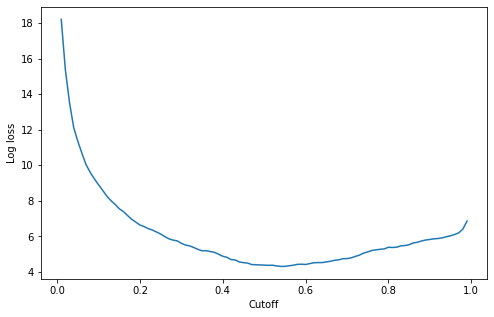

In [ ]:
#Plot Log loss vs Cutoff, and find exact Cutoff

cutoff = np.arange(0.01, 1, 0.01)
log_loss = []
for c in cutoff:
    log_loss.append(
        sklearn.metrics.log_loss(test.iloc[:,0], np.where(predictions > c, 1, 0))
    )

plt.figure(figsize=(8,5))
plt.plot(cutoff,log_loss)
plt.xlabel("Cutoff")
plt.ylabel("Log loss")
plt.show()

In [ ]:
print('Log loss is minimized at a cutoff of', cutoff[np.argmin(log_loss)],
    ', and the log loss value at the minimum is', np.min(log_loss))

Clean up

In [ ]:
# Delete endpoint
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

In [ ]:
#Delete training artifacts and S3 bucket
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

Finally, Stop and delete SageMaker Notebook instance.